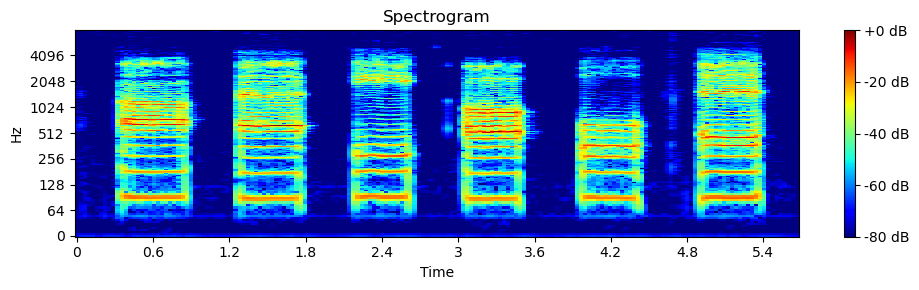

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
from scipy.spatial.distance import cdist
# Loading the audio file
x, fs = librosa.load("aeiouy.wav", sr=None)

# Setting the window length
win = round(fs * 0.2)

# Generating the spectrogram
S = librosa.stft(x, n_fft=win, hop_length=win//4)
D = librosa.amplitude_to_db(np.abs(S), ref=np.max)

# Plotting the spectrogram
plt.figure(figsize=(10, 3))
librosa.display.specshow(D, sr=fs, x_axis='time', y_axis='log', cmap='jet')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')
plt.tight_layout()
plt.show()


Etykietowanie danych
W kolejnych kolumnach macierzy znajdują się:

    numer okienka
    numer prążka
    częstotliwość prążka
    numer etykiety

Częstotliwość bazowa dla danego okienka wyznaczana jest przez podzielenie częstotliwości prążka przez jego numer.

In [53]:
sel = np.array([
    [5, 11, 1012, 1],
    [6, 11, 1006, 1],
    [7, 11, 1004, 1],
    [8, 11, 1012, 1],
    [15, 10, 880, 2],
    [16, 10, 884, 2],
    [17, 10, 888, 2],
    [18, 10, 890, 2],
    [24, 9, 840, 3],
    [25, 9, 845, 3],
    [26, 9, 830, 3],
    [27, 9, 834, 3],
    [33, 11, 966, 4],
    [34, 11, 959, 4],
    [35, 11, 975, 4],
    [36, 11, 975, 4],
    [43, 6, 545, 5],
    [44, 6, 545, 5],
    [45, 6, 539, 5],
    [46, 6, 539, 5],
    [52, 7, 642, 6],
    [53, 7, 644, 6],
    [54, 7, 637, 6],
    [55, 7, 638, 6],
])

labels = ['a', 'e', 'i', 'o', 'u', 'y']

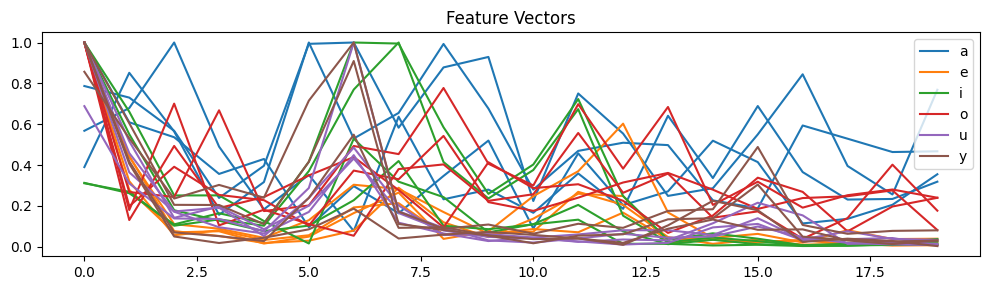

In [54]:

# Feature extraction
n_peaks = 20
n_frames = sel.shape[0]
feats = np.zeros((n_frames, n_peaks))

for row in range(n_frames):
    f0 = sel[row, 2] / sel[row, 1]
    frame_id = sel[row, 0] - 1  # Adjusting index for Python
    frame = np.abs(S[:, frame_id])
    frequencies = np.linspace(0, fs/2, len(frame))
    feats[row, :] = np.interp(np.arange(1, n_peaks + 1) * f0, frequencies, frame)
    feats[row, :] /= np.max(feats[row, :])

# Visualization of feature vectors
plt.figure(figsize=(10, 3))
for k in range(len(labels)):
    ids = sel[:, 3] == k + 1  # Adjusting index for labels
    for id in np.where(ids)[0]:
        plt.plot(feats[id, :], label=labels[k] if id == np.where(ids)[0][0] else "", color='C{}'.format(k))
plt.legend()
plt.title('Feature Vectors')
plt.tight_layout()

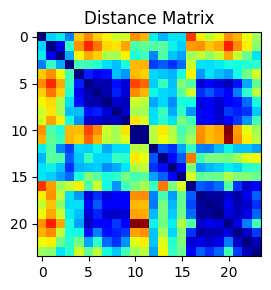

In [55]:

# Distance matrix between feature vectors
distance_matrix = cdist(feats, feats, 'cosine')

# Visualization of the distance matrix
plt.figure(figsize=(3, 3))
plt.imshow(distance_matrix, cmap='jet', interpolation='nearest')
plt.title('Distance Matrix')
plt.tight_layout()


Wizualizacja odległości kosinusowej pomiędzy głoskami

In [56]:
def get_voiced_segments(x, fs):
    # This function should implement the logic to find voiced segments in the audio.
    # Placeholder segments are returned here.
    return np.array([
        [13400, 14200, 89.15],
        [32800, 33800, 92.80]
    ])
    #returns first, last sample and base frequency


def classify(query, features, ids):
    distances = cdist([query], features, 'cosine')
    min_id = np.argmin(distances)
    return ids[min_id]

In [57]:
def get_amp(x, fs):
    L = x.shape[0]
    Y = np.fft.fft(x)
    A = np.abs(Y) / L
    A = A[:L // 2 + 1]
    A[1:-1] *= 2
    f_step = fs / L
    f = np.arange(0, fs / 2, f_step)
    return f, A


1. Po przetestowaniu
2. wykonać własne nagranie z wypowiadanymi samogłoskami i odpowiednio zaktualizować informacje referencyjne

In [58]:
#pitchwin z poprzedniego zadania
def pitchwin(x, fs, win):
    pitch_contour = []

    for i in range(0, len(x), win):
        x_window = x[i:i+win]

        autocorr = np.correlate(x_window, x_window, mode='full')

        autocorr = autocorr[len(autocorr)//2:]

        autocorr /= np.max(autocorr)

        lag_min = int(fs // 500)
        lag_max = int(fs // 80)

        lag_range = np.arange(lag_min, lag_max + 1)
        max_peak_index = lag_range[np.argmax(autocorr[lag_min:lag_max + 1])]
        pitch = fs / max_peak_index

        pitch_contour.append(pitch)

    pitch_contour = np.repeat(pitch_contour, win)[:len(x)]

    return pitch_contour


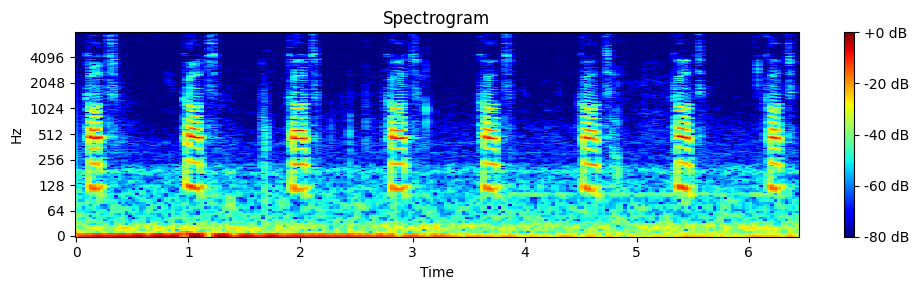

In [310]:
# Loading the audio file
x, fs = librosa.load("data_origins/kot.wav", sr=None)

# Setting the window length
win = round(fs * 0.2)

# Generating the spectrogram
S = librosa.stft(x, n_fft=win, hop_length=win//4)
D = librosa.amplitude_to_db(np.abs(S), ref=np.max)

# Plotting the spectrogram
plt.figure(figsize=(10, 3))
librosa.display.specshow(D, sr=fs, x_axis='time', y_axis='log', cmap='jet')
# plt.specgram(D, NFFT=1024, Fs=fs)
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')
plt.tight_layout()
plt.show()

Wizualizacja powtarzalnego słowa kot na spektrum.

In [61]:
def label(x, fs, energy_threshold=0.2):
    # Length of analysis window: 200 ms
    win = int(fs * 0.2)

    # Instantaneous energy
    ste = np.convolve(x ** 2, np.ones(win), 'same')
    ste = ste / np.max(ste)

    # Square root version
    str_ = np.sqrt(ste)

    zcr = sliding_zcr(x, int(fs * 0.1))

    # Calculate labels based on energy threshold
    lbls = np.zeros_like(x)
    lbls[(ste > energy_threshold) | (str_ > energy_threshold)] = 1
    lbls[(lbls == 1) & (zcr < 0.20)] = 2

    return lbls

def sliding_zcr(x, win):
    zcr = np.zeros(len(x))
    for i in range(len(x)):
        start = max(0, i - win)
        end = min(len(x), i + win)
        zc = np.diff(np.sign(x[start:end]))
        zcr[i] = np.sum(zc != 0) / (end - start)
    return zcr


def show_voiced(filename):
    
    x, fs = librosa.load(filename, sr=None)
    
    print(fs)
    
    # Normalize audio
    x = x / np.max(np.abs(x))
    
    lbls = label(x, fs)
    
    f0 = pitchwin(x, fs, round(fs * 0.1))
    
    f0[lbls != 2] = 0
    
    # Create separate signals based on labels
    silence = np.copy(x)
    silence[lbls != 0] = 0
    
    unvoiced = np.copy(x)
    unvoiced[lbls != 1] = 0
    
    voiced = np.copy(x)
    voiced[lbls != 2] = 0
    
    # Plot signals
    plt.figure()
    plt.title("Signal Segmentation")
    plt.plot(unvoiced, label="Unvoiced")
    plt.plot(voiced, label="Voiced")
    plt.plot(silence, label="Silence")
    plt.ylim(-1, 1)
    plt.legend()
    plt.show()
    
    plt.figure()
    plt.plot(f0)
    plt.title("Pitch Contour")
    plt.show()


Po przetesowaniu metod hadkodowania ,,prążków" klasyfikator który powstał tą metodą miał bardzo słabą efektywność.   
Zdecydowaliśmy się więc na ogólniejsze rozwiązanie problemu rozpoznawania słów czyli konwolucyjną sieć neuronową.

rozpoczeliśmy od stworzenia data setu po przez nagranie wielu próbek w jedny pliku dla tego samego słowa a następnie stworzenie funkcji która potnie  
nagranie na próbki poszczególnych słów na podstawie liczenia chwilowej energi sygnału dzwiękowego.

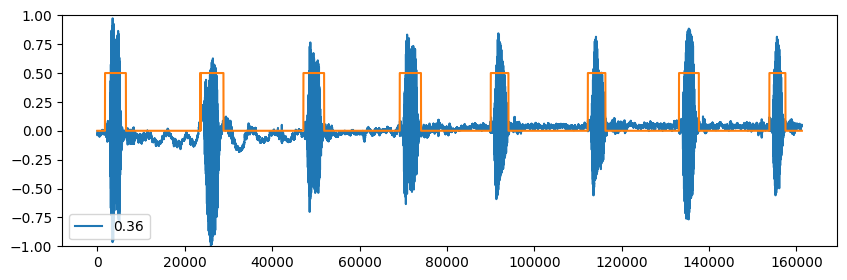

In [320]:

# funkcja pomocnicza wykorzystana do wizualizacji chwilowego poziomu energi danego nagrania
def show_silence(filename, threshold):

    x, fs = librosa.load(filename, sr=None)
    x = x - np.mean(x)
    x = x / np.max(np.abs(x))

    # Length of analysis window: 200 ms 
    
    win = int(fs * 0.2)
    
    # Instantaneous energy
    ste = np.convolve(x ** 2, np.ones(win), 'same')
    ste = ste / np.max(ste)
    
    # Square root version
    str_ = np.sqrt(ste)
    
    
    average_ste = np.sum(ste)
    average_str = np.zeros_like(str_)


    mask = str_ > threshold
   
    # second window of matlab notebook
    plt.figure(figsize=(10, 3))
    plt.plot(x)
    plt.ylim(-1, 1)
    # plt.plot(0.2 * (ste > 0.05))
    # plt.plot(0.4 * (ste > 0.01))
    plt.plot(0.5 * mask)
    # plt.plot(0.6 * (str_ > 0.05))
    # plt.plot(0.8 * (str_ > 0.01))
    plt.legend([threshold], loc="lower left")
    
    
    plt.show()
    return average_ste, average_str
average_ste, average_str = show_silence("data_origins/kot.wav", 0.36)

w przypadku jednorodnych próbek oraz w miarę izolowanego środowiska ta metoda jest wystarczająca dla 
pocięcia próbek w momencie gdy możemy ręcznie dopasować próg decyzyjny
mogliśmy zasotosować dodatkowo ZCR by wykrywanie było bardziej dokładne przy większym zaszumieniu ale nie było to konieczne.

In [193]:
import soundfile as sf

# parametry które mówią ile próbek przed i za wykrytym oknem z dużą energią sygnału(słowo) będzie dodane do wyciętego fragmentu
# jest to wymagane aby nie ucinać nagrania poszczególnego słowa za wcześnie gdy jego głośność już spada ale dalej niesie ważną informacje o tym jakie to jest słowo
end_addition = 3000
start_addition = 200

def split_audio_on_energy(filename, threshold=0.05, segment_folder=None):
    # Load audio
    x, fs = librosa.load(filename, sr=None)
    x = x - np.mean(x)
    x = x / np.max(np.abs(x))

    # Window length for 200 ms
    win = int(fs * 0.2)

    # Calculate short-time energy
    ste = np.convolve(x ** 2, np.ones(win), 'same')
    ste = ste / np.max(ste)

    # Calculate square root energy
    

    # Prepare segment folder
    if segment_folder is None:
        segment_folder = os.path.splitext(filename)[0] + '_cut'
    os.makedirs(segment_folder, exist_ok=True)

    # Find segments where energy is above the threshold
    mask = ste > threshold
    starts = np.where(np.diff(mask.astype(int)) == 1)[0]
    ends = np.where(np.diff(mask.astype(int)) == -1)[0]

    # If mask starts with True, prepend a start at 0
    if mask[0]:
        starts = np.insert(starts, 0, 0)

    # If mask ends with True, append an end at the length of the mask
    if mask[-1]:
        ends = np.append(ends, len(mask))

        

        starts = np.maximum(starts - start_addition, 0)
    ends = np.minimum(ends + end_addition, len(x))

    # Save segments
    segment_files = []
    for start, end in zip(starts, ends):
        segment_filename = os.path.join(segment_folder, f'segment_{start}_{end}.wav')
        sf.write(segment_filename, x[start:end], fs)
        segment_files.append(segment_filename)

    return segment_files

# Example of usage
# segment_files = split_audio_on_energy("data/kot.wav", threshold=0.12)




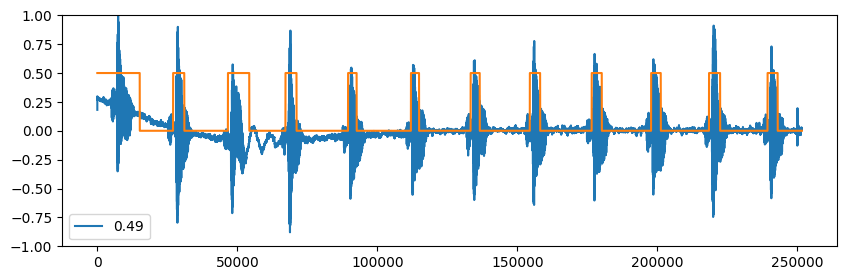

In [330]:
threshold = 0.49
average_ste, average_str = show_silence("data_origins/dom.wav",threshold )
segment_files = split_audio_on_energy("data_origins/dom.wav", threshold=threshold)

Przy każdym nagraniu było wymagane ręczne dopasowanie ilości próbek przed oraz za wykrytym oknem aby ,,złapać" całe słowo. 

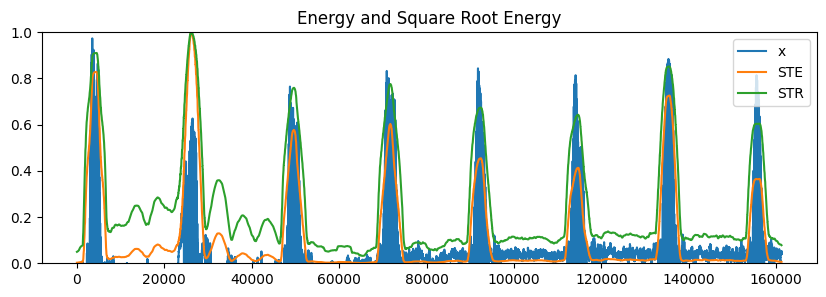

why its not printed


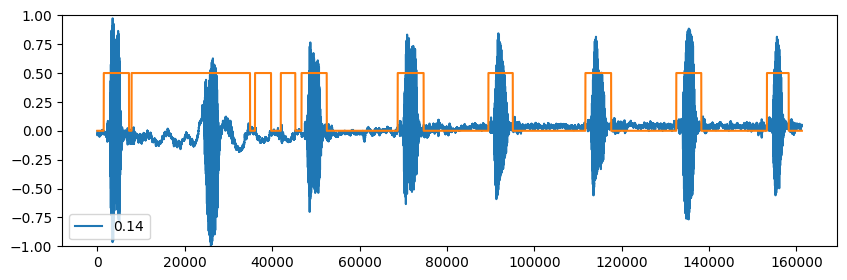

In [142]:
#experimental way of determining the best threashold for cutting
average_ste, average_str = show_silence("data/kot.wav",0.14)
segment_files = split_audio_on_energy("data/kot.wav", threshold=0.14)

Czasami lepiej było ustawić mniejszy próg decyzyjny i po prostu usunąć fragmęty z szumem by od razu mieć dopasowane ,,okno" do szerokości słowa.

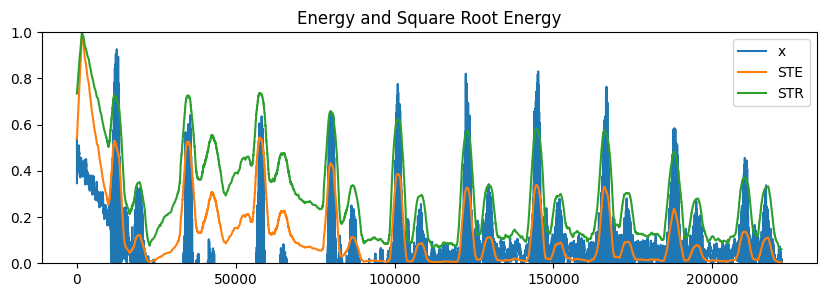

why its not printed


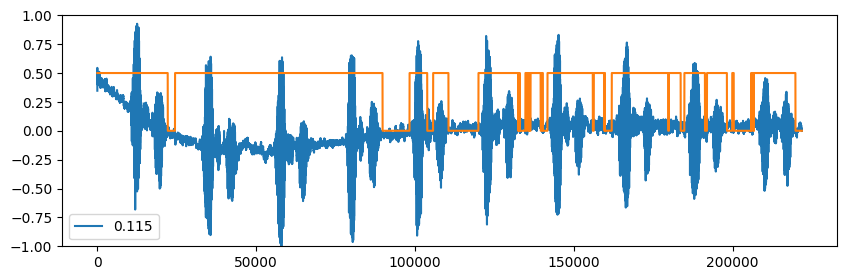

In [151]:
average_ste, average_str = show_silence("data/placki.wav",0.115)
segment_files = split_audio_on_energy("data/placki.wav", threshold=0.115)

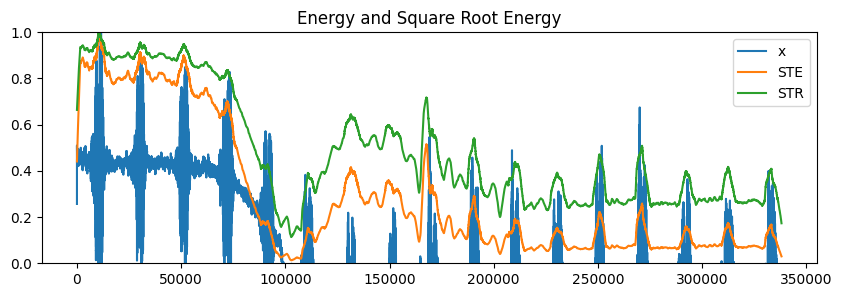

why its not printed


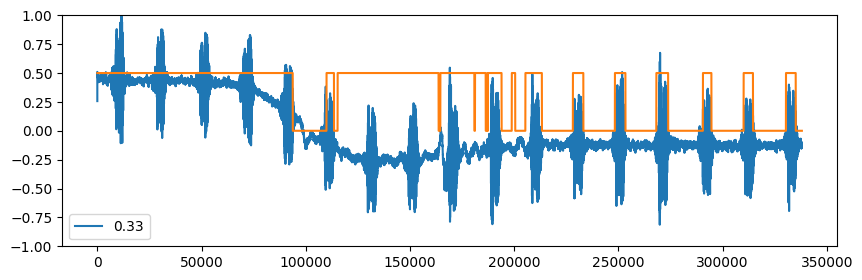

In [155]:
average_ste, average_str = show_silence("data/siema.wav",0.33)
segment_files = split_audio_on_energy("data/siema.wav", threshold=0.33)

W rezultacie otrzymaliśmy training oraz testing dataset w postaci folderów z plikami wav zawierającymi po jednym słowie każdy.

In [300]:
import numpy as np

def load_data(dataset_path):
    labels = []
    features = []

    # Iterate through each folder corresponding to a category
    for folder in os.listdir(dataset_path):
        label = folder
        print("Processing ", label)
        # Iterate through each audio file in the folder
        for file in os.listdir(os.path.join(dataset_path, folder)):
            path = os.path.join(dataset_path, folder, file)
            # Load the audio file
            audio, sr = librosa.load(path, sr=None)
            # Convert to Mel spectrogram
            mel_spect = librosa.feature.melspectrogram(y=audio, sr=sr, n_fft=2048, hop_length=1024)
            # Convert power spectrogram to decibel units
            mel_spect = librosa.power_to_db(mel_spect, ref=np.max(mel_spect))

            # Normalize the spectrogram
            norm_mel_spect = (mel_spect - np.min(mel_spect)) / (np.max(mel_spect) - np.min(mel_spect))

            # Ensure the spectrogram is properly sized (reshape or padding might be needed)
            if norm_mel_spect.shape != (128, 128):  # Example target shape, adjust as needed
                norm_mel_spect = np.pad(norm_mel_spect, ((0, max(0, 128 - norm_mel_spect.shape[0])), (0, max(0, 128 - norm_mel_spect.shape[1]))), mode='constant')

            # Append the spectrogram and the corresponding label to the dataset
            features.append(norm_mel_spect)
            labels.append(label)

    # Convert lists to numpy arrays
    features = np.array(features)
    labels = np.array(labels)

    return features, labels
features, labels = load_data('data')
features, labels

Processing  dom_cut_final
Processing  placki_cut_final
Processing  kot_cut_final


(array([[[0.64395726, 0.624421  , 0.6069053 , ..., 0.        ,
          0.        , 0.        ],
         [0.48670474, 0.5312344 , 0.547969  , ..., 0.        ,
          0.        , 0.        ],
         [0.5169844 , 0.46989718, 0.5205821 , ..., 0.        ,
          0.        , 0.        ],
         ...,
         [0.        , 0.07665577, 0.15477142, ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.09829521, 0.19843702, ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.00731945, 0.09592552, ..., 0.        ,
          0.        , 0.        ]],
 
        [[0.886339  , 0.8825965 , 0.8900882 , ..., 0.        ,
          0.        , 0.        ],
         [0.7666656 , 0.51680833, 0.48933044, ..., 0.        ,
          0.        , 0.        ],
         [0.7068189 , 0.53582263, 0.5120095 , ..., 0.        ,
          0.        , 0.        ],
         ...,
         [0.23903975, 0.11017084, 0.10102701, ..., 0.        ,
          0.        , 0.

Następnie, zasowaliśmy konwersję w zakresie częstotliwości za pomocą skali melowej oraz przekrztałciliśmy sygnał w spektrum w skali logarytmicznej(cepstrum).
Zabiegi te, były konieczne by odwzorować charakterystyki amplitudowe oraz częstotliwościowe ludzkiego ucha.

In [331]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2

# Number of classes
num_classes = len(np.unique(labels))

model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(features.shape[1], features.shape[2], 1), kernel_regularizer=l2(0.01)),  
    #dodanie regulatora l2 aby spenalizować wysokie wagi które prowadziły do przeuczenia się modelu przy tak małej ilości 
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),     
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),         
    Dropout(0.5),                                    
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)              │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_12 (Flatten)            │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 128)            │     7,372,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,392,131 (28.20 MB)

 Trainable params: 7,392,131 (28.20 MB)

 Non-trainable params: 0 (0.00 B)

Używamy tutaj konwolucyjnej sieci neuronowej która działa tak samo na mel cepstrum jakby działała na obrazie - warstwy conv2d tworzą filtry róznych wielkości które wykrywają krztałty w spektrum. Po każdej warstwie splotowej jest warstwa pooling która zmniejsza rozmiar po warstwach splotowych następuje ,,wypłaszczenie" danych aby mogły zostać przetworzone przez warstwy głębokie które uczą się bardziej skomplikowanych i nieliniowych zależności. Pod koniec, przekazują to do trzech neuronów wyjściowych z których każdy określa prawdopodobieństwo z jakim wykryte zostało konkretne słowo.  

In [303]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Encode labels into integers
le = LabelEncoder()
labels_encoded = le.fit_transform(labels)
labels_encoded = to_categorical(labels_encoded)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(features, labels_encoded, test_size=0.2, random_state=42)

# Reshape for the CNN input
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]

history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 432ms/step - accuracy: 0.2771 - loss: 3.8744 - val_accuracy: 0.9000 - val_loss: 2.7090
Epoch 2/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 246ms/step - accuracy: 0.5708 - loss: 2.6758 - val_accuracy: 0.9000 - val_loss: 1.8566
Epoch 3/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 234ms/step - accuracy: 0.5813 - loss: 1.9151 - val_accuracy: 0.8000 - val_loss: 1.4753
Epoch 4/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 295ms/step - accuracy: 0.5979 - loss: 1.5277 - val_accuracy: 0.5000 - val_loss: 1.3144
Epoch 5/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 277ms/step - accuracy: 0.7396 - loss: 1.3026 - val_accuracy: 0.5000 - val_loss: 1.2813
Epoch 6/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 222ms/step - accuracy: 0.7167 - loss: 1.2784 - val_accuracy: 0.8000 - val_loss: 1.1308
Epoch 7/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 247ms/step - accuracy: 0.8042 - loss: 1.2944 - val_accuracy: 0.9000 - val_loss: 1.0087
Epoch 8/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 265ms/step - accuracy: 0.8146 - loss: 1.2288 - val_accuracy: 0.9000 - val_loss:

Standardowy podział na dane testowe oraz treningowe i trenowanie modelu.

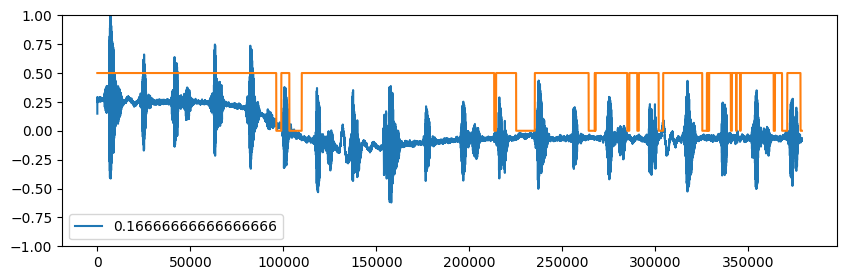

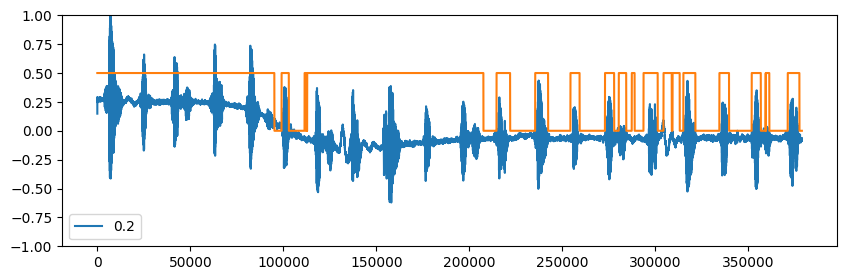

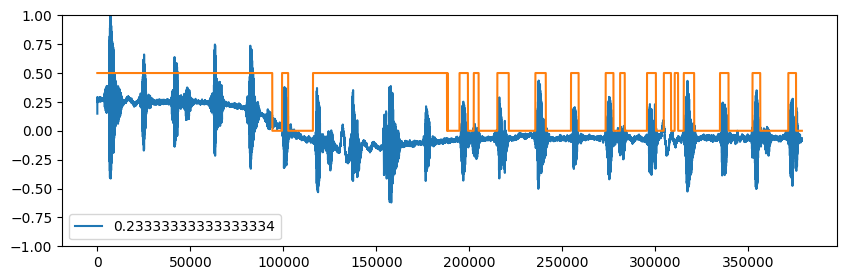

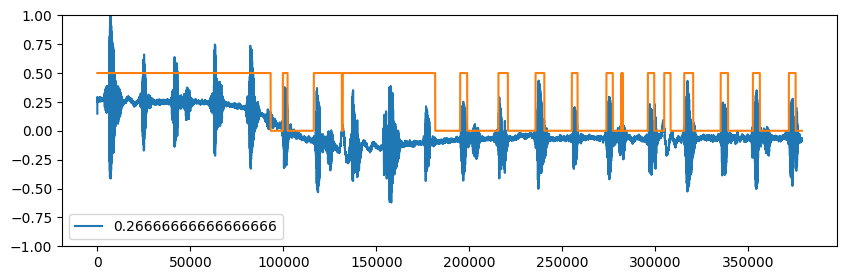

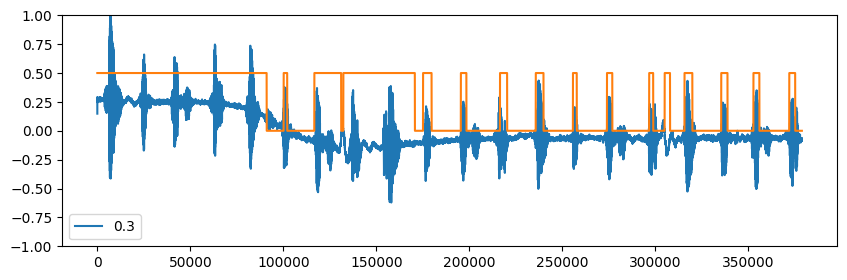

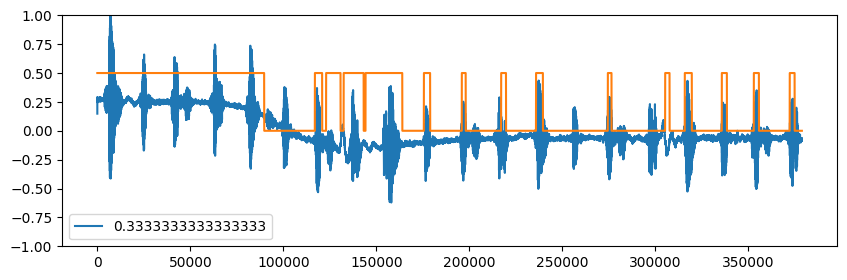

In [332]:
#creating test data
temp_threshold = 0.3
#iterating over different experimental values for threshold for extracting different recorded words with different levels of power
for temp_threshold in range (5,11,1):
    average_ste, average_str = show_silence("data_origins/dom_kot_placki_siema_test.wav",threshold=temp_threshold/30)
    segment_files = split_audio_on_energy("data_origins/dom_kot_placki_siema_test.wav", threshold=temp_threshold/30)
    

Przygotowanie danych testowych z nagrania zawierającego wymieszane słowa.   
Iteracyjne przejście przez wielkość okna aby wyłonić różne słowa o róznych energiach.    
Następnie przejrzeliśmy pocięte nagrania i wyłoniliśmy z nich te które się nadawały do testowania.    


In [ ]:
#przekrztałcanie danych do melcepstrogramu aby dane testowe były tak samo przerabiane jak te użyte do trenowania
import os
import numpy as np
import librosa
norm_mel_spect = None
def preprocess_audio_file(file_path, target_shape=(128, 128)):
    # Load the audio file
    audio, sr = librosa.load(file_path, sr=None)
    # Convert to Mel spectrogram
    mel_spect = librosa.feature.melspectrogram(y=audio, sr=sr, n_fft=2048, hop_length=1024)
    # Convert power spectrogram to decibel units
    mel_spect = librosa.power_to_db(mel_spect, ref=np.max(mel_spect))
    # Normalize the spectrogram
    global norm_mel_spect 
    norm_mel_spect = (mel_spect - np.min(mel_spect)) / (np.max(mel_spect) - np.min(mel_spect))
    # Resize/pad the spectrogram to match the target shape
    if norm_mel_spect.shape != target_shape:
        norm_mel_spect = np.pad(norm_mel_spect, ((0, max(0, target_shape[0] - norm_mel_spect.shape[0])), (0, max(0, target_shape[1] - norm_mel_spect.shape[1]))), mode='constant')
    # Add a channel dimension if your model expects it
    norm_mel_spect = norm_mel_spect[np.newaxis, ..., np.newaxis]  # Example for a model expecting (None, 128, 128, 1)
    return norm_mel_spect

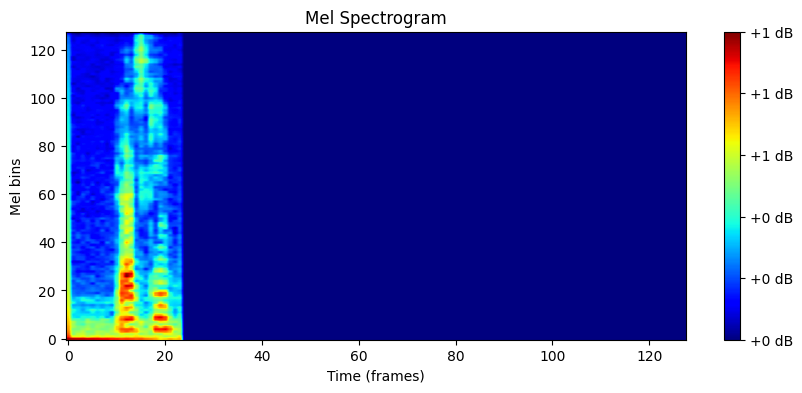

In [346]:
target_shape=(128, 128)
audio, sr = librosa.load("data/placki_cut_final/placki1.wav", sr=None)
mel_spect = librosa.feature.melspectrogram(y=audio, sr=sr, n_fft=2048, hop_length=1024)
mel_spect = librosa.power_to_db(mel_spect, ref=np.max(mel_spect))
norm_mel_spect = (mel_spect - np.min(mel_spect)) / (np.max(mel_spect) - np.min(mel_spect))
if norm_mel_spect.shape != target_shape:
    norm_mel_spect = np.pad(norm_mel_spect, ((0, max(0, target_shape[0] - norm_mel_spect.shape[0])), (0, max(0, target_shape[1] - norm_mel_spect.shape[1]))), mode='constant')


plt.figure(figsize=(10, 4))
plt.imshow(norm_mel_spect, aspect='auto', origin='lower',cmap="jet")
plt.title('Mel Spectrogram')
plt.ylabel('Mel bins')
plt.xlabel('Time (frames)')
plt.colorbar(format='%+02.0f dB')
plt.show()

Pokazanie co ,,widzi" sieć.

In [308]:

# tworzenie listy plików do finalnego przetestowania modelu
folder_name = "test_final/"
file_list = []
labels = ["dom","kot","placki"]
true_positives = 0
all_words = 0

for file in os.listdir(folder_name):
    
    path = os.path.join(folder_name, file)
    file_list.append(path)
    
    preprocessed_audio = preprocess_audio_file(path)
    # inferencja w modelu
    predictions = model.predict(preprocessed_audio)
    print(predictions)
    
    #wybieranie neuronu z największą aktywacją czyli które słowo zostało wykryte
    predicted_label_index = np.argmax(predictions)
    predicted_label = labels[predicted_label_index]
    sample_name = os.path.split(path)[1]
    
    # printowanie
    print("label|file")
    print(predicted_label,"|", sample_name)
    if predicted_label in sample_name: 
        print("✔️")
        true_positives += 1
        all_words += 1
    else:
        print("🚫")
        all_words += 1
    print("\n")
print("Accuracy: ", true_positives/all_words)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
[[0.05542551 0.1163934  0.8281811 ]]
label|file
placki | placki3.wav
✔️


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
[[0.9556695  0.03288335 0.01144721]]
label|file
dom | dom7.wav
✔️


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
[[0.63401175 0.18343225 0.18255596]]
label|file
dom | kot4.wav
🚫


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
[[0.70356584 0.27912158 0.0173125 ]]
label|file
dom | dom6.wav
✔️


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
[[0.5685505  0.18829693 0.24315256]]
label|file
dom | kot2.wav
🚫


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
[[0.14824349 0.07716137 0.77459514]]
label|file
placki | placki8.wav
✔️


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
[[9.9794978e-01 6.3445308e-04 1.4157838e-03]]
label|file
dom | dom3.wav
✔️


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
[[0.01997731 0.92247516 0.05754761]]
label|file
kot | kot3.wav
✔️


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
[[0.98870766 0.00973535 0.00155696]]
label|file
dom | dom5.wav
✔️


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s

#### Dokładność końcowa modelu: 84% 